## Trapezoidal rule
__MATH 420__ <br>
_Spring 2021_ <br>

Here is a Julia implementation of the n-panel trapezoidal rule.  

In [26]:
function trapezodial_rule(F::Function, a::Number, b::Number, n::Integer)::Number
    h = (b-a)/n           # step size; a negative value for h is OK!
    s = (F(a) + F(b))/2   # weights at endpoints is 1/2
    for k in 1:(n-1)
      s += F(a+h*k)
    end
    h*s
end

trapezodial_rule (generic function with 1 method)

Suggestions for improvement:

- Throw an argument error when `n==0`.

- Use `fma` to evaluate `a+h*k`. But this will fail for complex numbers. There are workarounds, of course.

- Use Kahan summation.

- Extend the code to functions of several variables.

- Write a docstring for this function

The trapezoidal rule is exact for polynomials of at most one. Let's check some integrands that are linear. The true value of each of the following is one:

In [2]:
 trapezodial_rule(x -> 1,0,1,1)

1.0

In [3]:
 trapezodial_rule(x -> 1,0,1,100)

1.0

In [4]:
 trapezodial_rule(x -> 2x, 0,1,1)

1.0

In [5]:
 trapezodial_rule(x -> 2x, 0,1,100)

1.0

If fast was our main goal, should replace ` F(a+h*k)` by updating the knot by adding `h` after each function evaluation

In [6]:
function trapezodial_rule2(F::Function, a::Number, b::Number, n::Integer)::Number
    h = (b-a)/n             # step size--a negative value for h is OK!
    s = (F(a) + F(b))/2     # weights at endpoints is 1/2
    a = a+h                 # overwrite a--that's OK!
    for _ in 1:n-1
      s += F(a)
      a += h
    end
    h*s
end

trapezodial_rule2 (generic function with 1 method)

Is it really any faster? Let's try
$$
 \int_0^{10} \exp(x) \, \mathrm{d} x = \exp(10) - 1
$$

Yes, but

In [7]:
using BenchmarkTools

In [8]:
(fn, a,b,n) = (exp, 0.0, 10.0, 10^7);

In [9]:
 I1 = @btime trapezodial_rule(fn,a,b,n)

  174.604 ms (1 allocation: 16 bytes)


22025.465794809206

In [10]:
I2 = @btime trapezodial_rule2(fn,a,b,n)


  50.080 ms (1 allocation: 16 bytes)


22025.465792513052

But wait! The values are different!  Which is more accurate? Subtracting the true value, we see that the slow and steady wins the race! The error using `trapezodial_rule` is _far less_ than the error for `trapezodial_rule2`

In [11]:
exact = exp(10.0) -1.0

22025.465794806718

In [12]:
I1 - exact

2.4883775040507317e-9

In [13]:
I2 - exact

-2.293665602337569e-6

What's the story? By the time `trapezodial_rule2` evaluates the last knot (in this case 10), it has computed this value with $10^7$ additions. Each addition gives an error bounded above by the machine epsilon. After doing this many additions, the value can differ a fair amount from its true value. To see this experimentally, add a line that shows the final value of $a$ to `trapezodial_rule2` 

In [14]:
function trapezodial_rule3(F::Function, a::Number, b::Number, n::Integer)
    h = (b-a)/n #step size--negative is OK
    s = (F(a) + F(b))/2 #weights at endpoints is 1/2
    a = a+h #overwrite a--that's OK!
    for k=1:n-1
      s += F(a)
      a += h
    end
    @show(a)
    h*s
end

trapezodial_rule3 (generic function with 1 method)

The true value of the last value of `a` is 10, but due to rounding errors it is $9.999999999267517$. 

In [15]:
trapezodial_rule3(fn,a,b,n)

a = 9.999999999267517


22025.465792513052

In the trade-off between speed and accuracy, I like to favor accuracy. Accordingly, let's stick to our first version of the trapezoidal rule.

Let's define $T_n$ to be the n-panel trapezoidal rule estimation to 
$$
  \int_0^{10} x \exp(x-10) \, \mathrm{d} x.
$$
Let's sketch the graph of $T$

In [16]:
using Gadfly

In [17]:
xx = [n for n=10:50];

In [18]:
yy  = [trapezodial_rule(x -> x*exp(x)/exp(10),0,10,n) for n = 10:50];

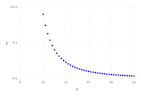

In [19]:
plot(x=xx,y=yy,color=[colorant"blue"])

The graph looks ``predictable.'' Surely we could use this predictability to extrapolate (go beyond the data) the graph and find more accurate value for the integral.

Actually, the theory is telling us that there is a constant $c_2$ such that
$$
  T_n = I + \frac{c_2}{n^2} + E_n
$$
where $I$ is the true value of the integral and
$$
  \lim_{n \to \infty} n^3 E_n = 0.
$$

The true value of the integral is $ I = 9 + \exp(-10)$. We have
$$
   \lim_{n \to \inf} (T_n - I) n^2 = c_2
$$


A bit better
$$
  T_{2n} = I + \frac{c_2}{4 n^2} + E_{2n},  \quad  T_{n} = I + \frac{c_2}{n^2} + E_{n}
$$
gives
$$
   I=\frac{4 \operatorname{T}\left( 2 n\right) }{3}-\frac{4 \operatorname{E}\left( 2 n\right) }{3}-\frac{\operatorname{T}(n)}{3}+\frac{\operatorname{E}(n)}{3}
$$
and
$$
 \mathit{c2}=-\frac{4 {{n}^{2}} \operatorname{T}\left( 2 n\right) }{3}+\frac{4 {{n}^{2}} \operatorname{E}\left( 2 n\right) }{3}+\frac{4 {{n}^{2}} \operatorname{T}(n)}{3}-\frac{4 {{n}^{2}} \operatorname{E}(n)}{3}
 $$
Assuming that the $E$ terms are small, we have
$$
  I = \frac{4}{3} T_{2n} - \frac{1}{3} T_n.
$$
This is the Simpson rule.

Let's try integrating 
$$
  \int_0^\pi \sin^2(x) \, \mathrm{d} x.
$$
The true value is $\pi/2$

In [20]:
xx = [n for n=10:50];

In [21]:
yy  = [trapezodial_rule(x -> sin(x)^2,0,pi,n) for n = 10:50];

This time, the graph doesn't look predictable--it looks like a jumpy mess! For the theory of this, learn about the Euler-Maclaurin summation formula.

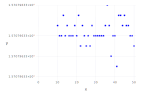

In [22]:
plot(x=xx,y=yy,color=[colorant"blue"])

And a graph of the true value minus the approximate value.

In [23]:
yy  = [trapezodial_rule(x -> sin(x)^2,0,pi,n) - pi/2 for n = 10:50];

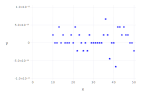

In [24]:
plot(x=xx,y=yy,color=[colorant"blue"])

Finally, let's look at what is ``out there.'' A search for "Julia code trapezoidal rule" comes up with the following code

In [25]:
function quad_trap(f,a,b,N) 
    h = (b-a)/N
    int = h * ( f(a) + f(b) ) / 2
    for k=1:N-1
        xk = (b-a) * k/N + a
        int = int + h*f(xk)
    end
    return int
end

quad_trap (generic function with 1 method)

Some comments:

- The first line in the `for` loop, that is `xk = (b-a) * k/N + a`, requires _five_ 
  floating point evaluations. It would be faster to do `xk = a + h*k`, as this requires only _three_ floating point evaluations.

- It's more efficient to factor multiplication by `h` outside the summation. The function `quad_trap` does about `n` unnecessary multiplications by `h`.

- I'm guessing that this code was intended to be a straightforward translation of the way the trapezoidal rule is often expressed in mathematical language, not as a model of efficiency,